In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss

In [10]:
df = pd.read_csv("data/hour.csv", parse_dates=["dteday"])
print(df.head())
print(df.info())

   instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1 2011-01-01       1   0     1   0        0        6           0   
1        2 2011-01-01       1   0     1   1        0        6           0   
2        3 2011-01-01       1   0     1   2        0        6           0   
3        4 2011-01-01       1   0     1   3        0        6           0   
4        5 2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 column

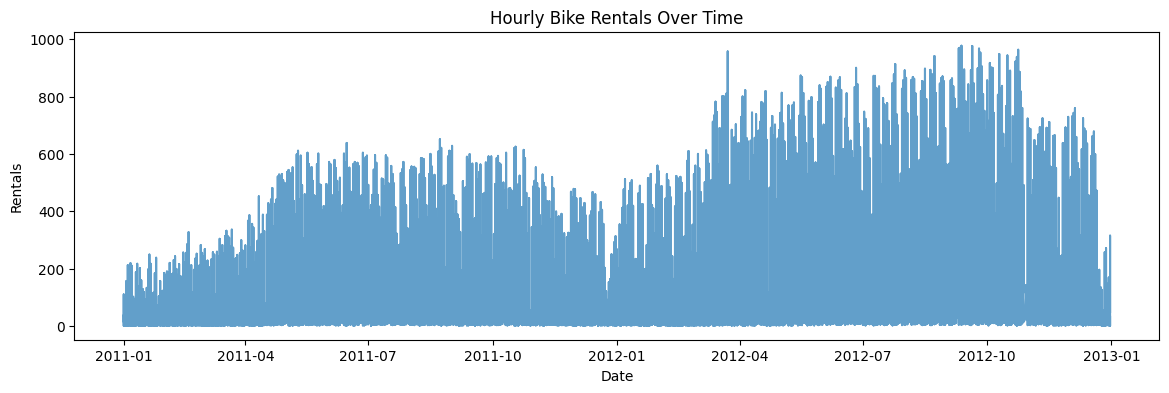

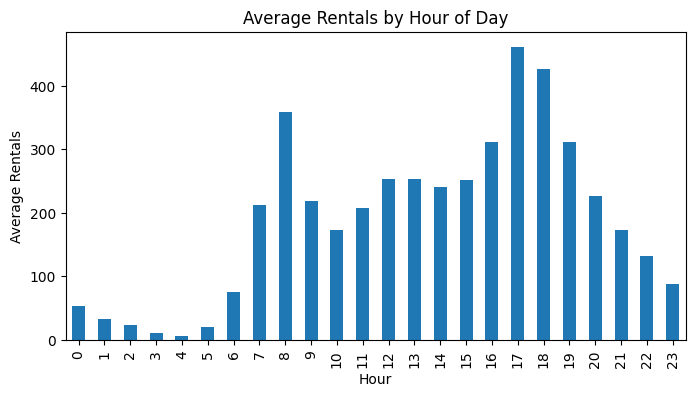

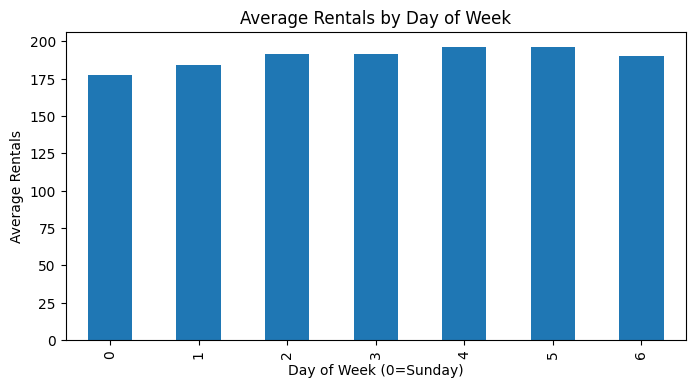

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64


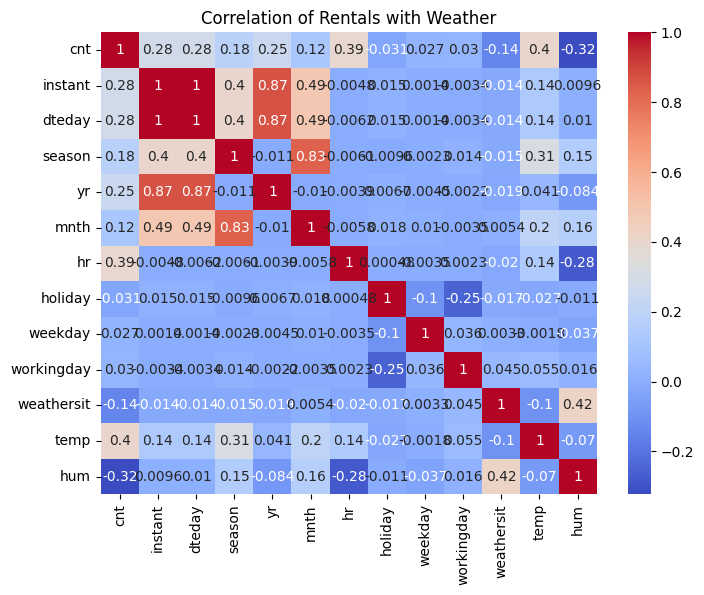

In [23]:


# 1. Plot overall trend
plt.figure(figsize=(14,4))
plt.plot(df['dteday'], df['cnt'], alpha=0.7)
plt.title("Hourly Bike Rentals Over Time")
plt.xlabel("Date")
plt.ylabel("Rentals")
plt.show()

# 2. Daily pattern: average rentals by hour of day
hourly_pattern = df.groupby('hr')['cnt'].mean()
plt.figure(figsize=(8,4))
hourly_pattern.plot(kind='bar')
plt.title("Average Rentals by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Average Rentals")
plt.show()

# 3. Weekly pattern
weekly_pattern = df.groupby('weekday')['cnt'].mean()
plt.figure(figsize=(8,4))
weekly_pattern.plot(kind='bar')
plt.title("Average Rentals by Day of Week")
plt.xlabel("Day of Week (0=Sunday)")
plt.ylabel("Average Rentals")
plt.show()

# 4. Quick stats
print(df['cnt'].describe())

# 5. Correlation heatmap with weather features
plt.figure(figsize=(8,6))
sns.heatmap(df[['cnt', 'instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation of Rentals with Weather")
plt.show()


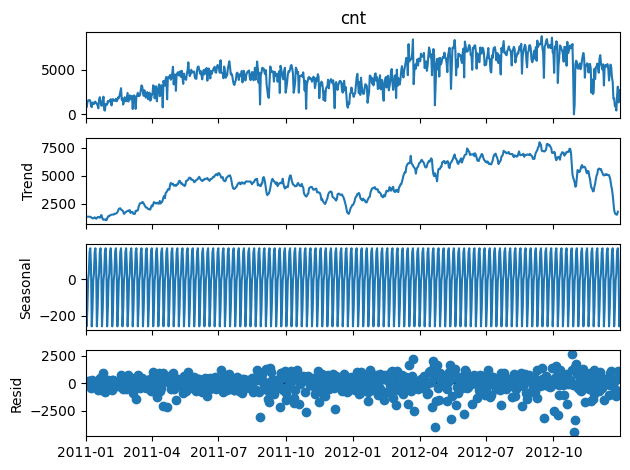

In [5]:


# 1. Aggregate to daily rentals
daily = df.groupby('dteday')['cnt'].sum()

# 2. Decompose (additive model is fine here)
result = seasonal_decompose(daily, model='additive', period=7)  # yearly seasonality

# 3. Plot
result.plot()
plt.show()


<Axes: xlabel='weekday', ylabel='hr'>

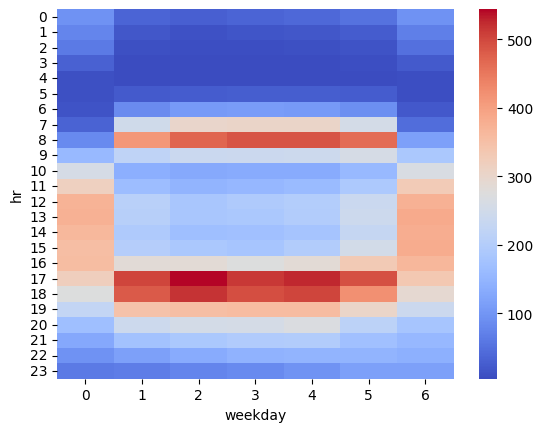

In [6]:

pivot = df.pivot_table(values='cnt', index='hr', columns='weekday', aggfunc='mean')
sns.heatmap(pivot, cmap="coolwarm")


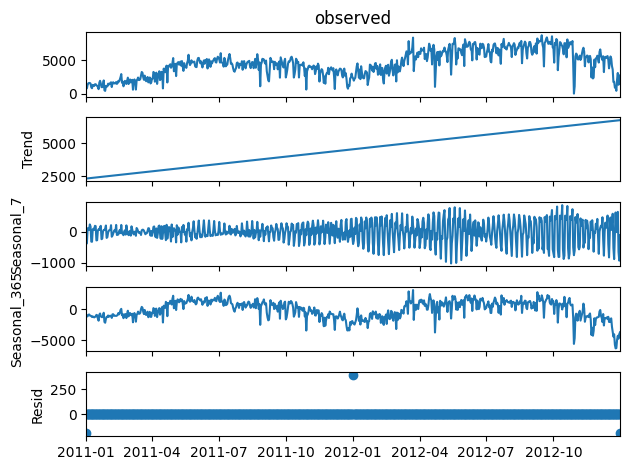

In [7]:
# Aggregate daily
daily = df.groupby('dteday')['cnt'].sum()

# Run MSTL with multiple seasonalities (no robust here)
mstl = MSTL(daily, periods=(7, 365))
res = mstl.fit()

# Plot
res.plot()
plt.show()

dteday
2011-01-01   -356.376637
2011-01-02   -378.262774
2011-01-03    106.371960
2011-01-04    122.472321
2011-01-05     61.421478
                 ...    
2012-12-27    330.055204
2012-12-28    643.186062
2012-12-29   -651.523306
2012-12-30   -934.458154
2012-12-31   -112.068674
Name: seasonal_7, Length: 731, dtype: float64


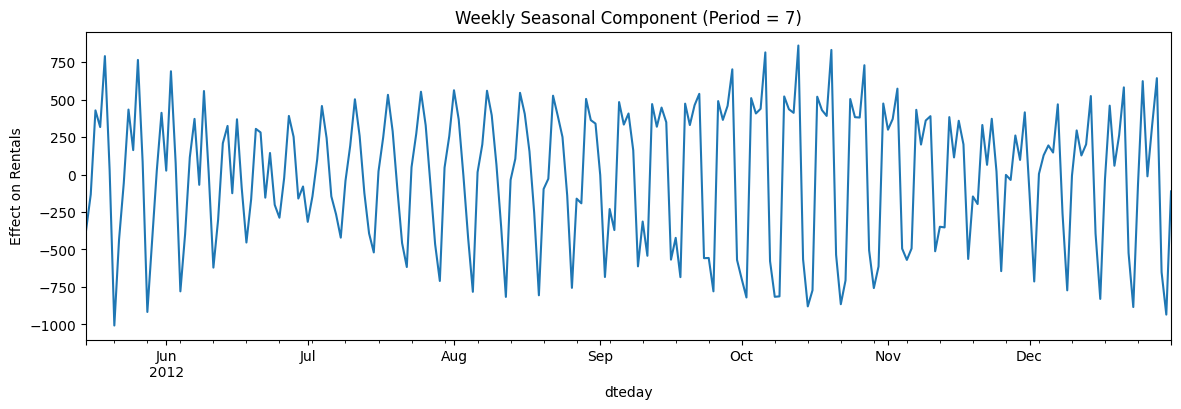

In [8]:
# After running MSTL
mstl = MSTL(daily, periods=(7, 365))
res = mstl.fit()

# Extract the weekly seasonal component (period=7)
weekly_seasonal = res.seasonal['seasonal_7'][500:]
print(res.seasonal['seasonal_7'])


# Plot it directly
plt.figure(figsize=(14,4))
weekly_seasonal.plot()
plt.title("Weekly Seasonal Component (Period = 7)")
plt.ylabel("Effect on Rentals")
plt.show()


/var/folders/xs/_grlrsv53b3cdgtz39xvn1f80000gn/T/ipykernel_11213/3542906406.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.asfreq('H')


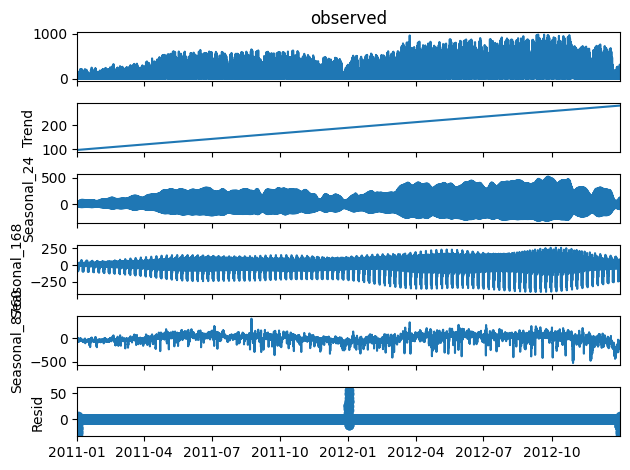

In [33]:


# 1) Build a proper hourly datetime index
# UCI columns: dteday (date) and hr (0–23)
dt = pd.to_datetime(df['dteday']) + pd.to_timedelta(df['hr'], unit='h')
s = pd.Series(df['cnt'].values, index=dt).sort_index()

# (Optional but recommended) enforce regular hourly frequency and fill tiny gaps
s = s.asfreq('H')
# choose a light fill method; forward fill is common for short gaps
s = s.ffill()

# 2) Three seasonal periods on hourly data
# 24 = daily cycle, 168 = weekly (7*24), 8760 ≈ yearly (365*24)
mstl = MSTL(s, periods=(24, 168, 8760))   # omit robust if your version doesn’t support it
res = mstl.fit()

# 3) Plot
res.plot()
plt.show()


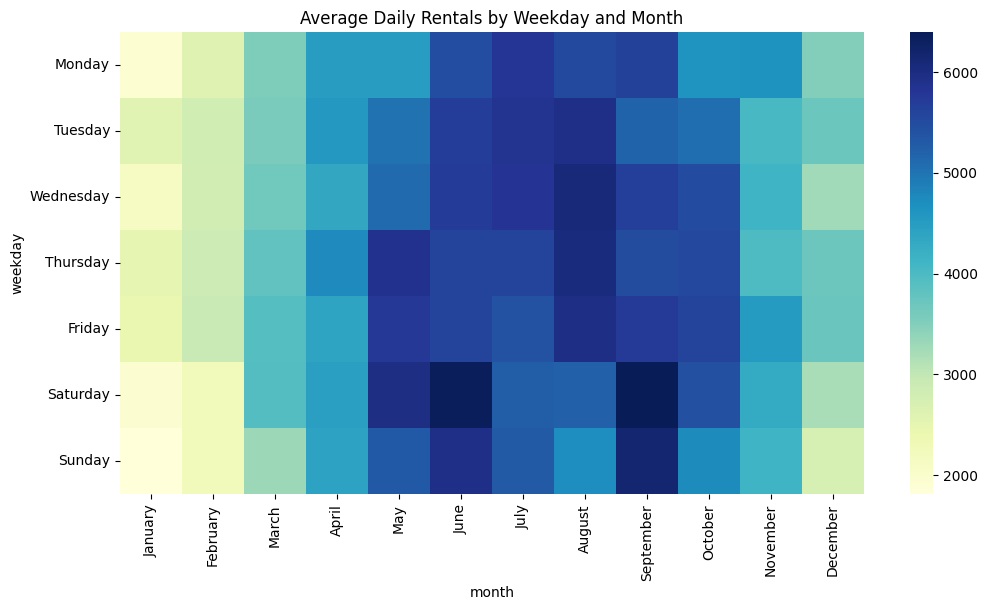

In [9]:


# Aggregate to daily demand
daily = df.groupby('dteday')['cnt'].sum().reset_index()

# Extract weekday and month
daily['weekday'] = daily['dteday'].dt.day_name()   # Monday, Tuesday, ...
daily['month'] = daily['dteday'].dt.month_name()   # January, February, ...

# Order categories (so they plot nicely)
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

# Build pivot table: average rentals by (weekday, month)
pivot = daily.pivot_table(values='cnt',
                          index='weekday',
                          columns='month',
                          aggfunc='mean')

# Reorder rows/cols
pivot = pivot.reindex(index=weekday_order, columns=month_order)

# Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=False, cmap="YlGnBu")
plt.title("Average Daily Rentals by Weekday and Month")
plt.show()


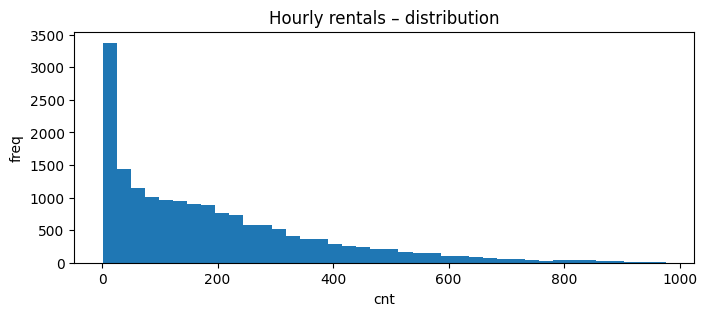

Hourly describe:
 count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64


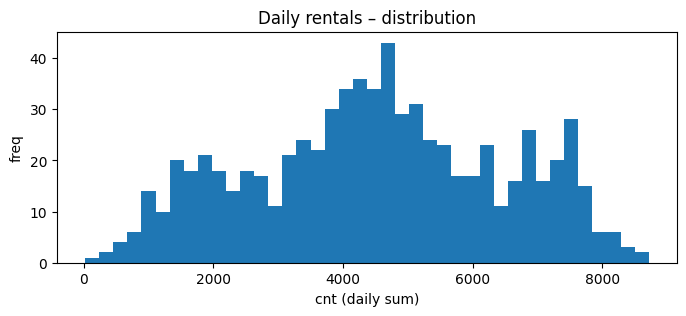

Daily describe:
 count     731.000000
mean     4504.348837
std      1937.211452
min        22.000000
25%      3152.000000
50%      4548.000000
75%      5956.000000
max      8714.000000
Name: cnt, dtype: float64
IQR low=-1054.0, high=10162.0, #outliers=0
Top extreme days:
 Series([], Freq: D, Name: cnt, dtype: int64)


In [11]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Build time index (UCI: dteday + hr)
dt = pd.to_datetime(df['dteday']) + pd.to_timedelta(df['hr'], unit='h')
df_ = df.copy()
df_['ts'] = dt
df_ = df_.set_index('ts').sort_index()

# Hourly histogram + quick stats
plt.figure(figsize=(8,3)); plt.hist(df_['cnt'].dropna(), bins=40)
plt.title("Hourly rentals – distribution"); plt.xlabel("cnt"); plt.ylabel("freq"); plt.show()
print("Hourly describe:\n", df_['cnt'].describe())

# Daily aggregation for a cleaner view
daily = df_.resample('D')['cnt'].sum()

plt.figure(figsize=(8,3)); plt.hist(daily.dropna(), bins=40)
plt.title("Daily rentals – distribution"); plt.xlabel("cnt (daily sum)"); plt.ylabel("freq"); plt.show()
print("Daily describe:\n", daily.describe())

# Robust outlier scan (IQR) on daily totals
q1, q3 = np.percentile(daily.dropna(), [25, 75])
iqr = q3 - q1
low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
outliers = daily[(daily < low) | (daily > high)].sort_values()
print(f"IQR low={low:.1f}, high={high:.1f}, #outliers={outliers.size}")
print("Top extreme days:\n", outliers.tail(10))


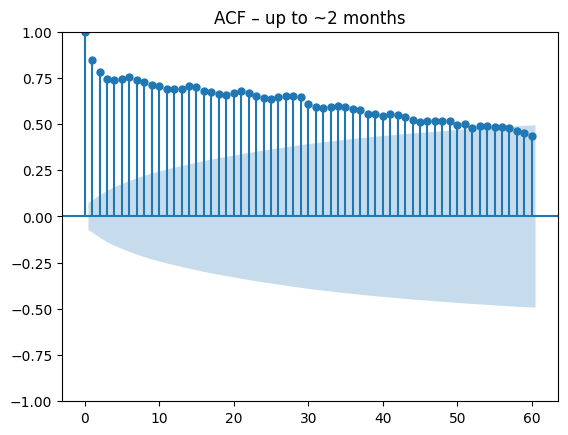

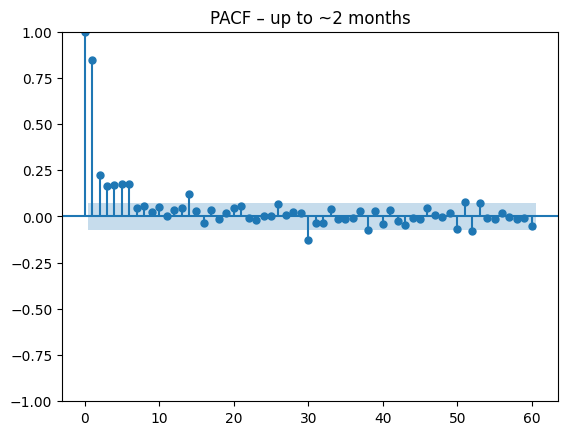

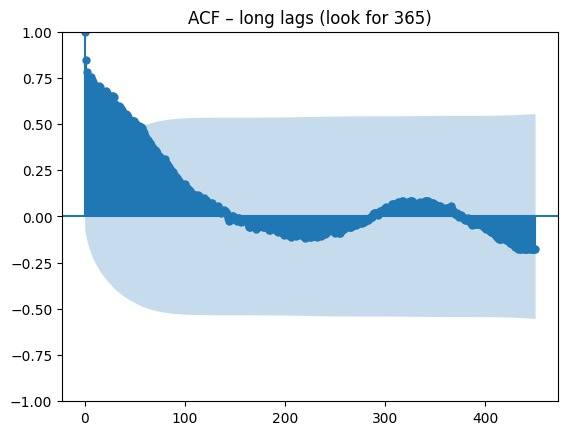

In [13]:

# Weekly structure (first 60 lags ~ 2 months)
plot_acf(daily.dropna(), lags=60); plt.title("ACF – up to ~2 months"); plt.show()
plot_pacf(daily.dropna(), lags=60); plt.title("PACF – up to ~2 months"); plt.show()

# Longer view to glimpse yearly (~365)
plot_acf(daily.dropna(), lags=450); plt.title("ACF – long lags (look for 365)"); plt.show()


In [18]:
# Choose split sizes (adjust if you like)
TEST_DAYS = 60
VAL_DAYS  = 60

# Define boundaries on daily index
end = daily.index.max()
test_start = end - pd.Timedelta(days=TEST_DAYS-1)
val_end = test_start - pd.Timedelta(days=1)
val_start = val_end - pd.Timedelta(days=VAL_DAYS-1)

print("Train:", daily.index.min().date(), "→", (val_start - pd.Timedelta(days=1)).date())
print("Val  :", val_start.date(), "→", val_end.date())
print("Test :", test_start.date(), "→", end.date())

# Boolean masks on the HOURLY frame so we can later build hourly features safely
df_['date'] = df_.index.date
df_['split'] = 'train'
df_.loc[(df_.index.date >= val_start.date()) & (df_.index.date <= val_end.date()), 'split'] = 'val'
df_.loc[df_.index.date >= test_start.date(), 'split'] = 'test'

# Example: create SAFE lag/rolling features (shift to avoid peeking)
def add_safe_lags(frame, target='cnt'):
    frame = frame.copy()
    frame[f'{target}_lag1']  = frame[target].shift(1)
    frame[f'{target}_lag24'] = frame[target].shift(24)
    frame[f'{target}_lag168']= frame[target].shift(168)  # 1 week for hourly
    frame[f'{target}_roll24']  = frame[target].shift(1).rolling(24, min_periods=12).mean()
    frame[f'{target}_roll168'] = frame[target].shift(1).rolling(168, min_periods=24).mean()
    return frame

df_feat = add_safe_lags(df_)

# Example: fit scalers on TRAIN only (targets or exogenous)

scaler_X = StandardScaler()

feature_cols = ['temp','atemp','hum','windspeed',
                'cnt_lag1','cnt_lag24','cnt_lag168','cnt_roll24','cnt_roll168']
# Keep only columns that exist
feature_cols = [c for c in feature_cols if c in df_feat.columns]

X_train = df_feat.loc[df_feat['split']=='train', feature_cols].dropna()
scaler_X.fit(X_train)  # fit on train

# Apply transform split-wise later before modeling


Train: 2011-01-01 → 2012-09-02
Val  : 2012-09-03 → 2012-11-01
Test : 2012-11-02 → 2012-12-31


,copy,True
,with_mean,True
,with_std,True


In [19]:


def adf_kpss_report(x, name="series"):
    x = x.dropna()
    adf_p = adfuller(x, autolag='AIC')[1]
    kpss_stat, kpss_p, *_ = kpss(x, regression='c', nlags='auto')
    print(f"[{name}]  ADF p={adf_p:.3g}  (p<0.05 ⇒ reject unit root ⇒ stationary)")
    print(f"[{name}] KPSS p={kpss_p:.3g} (p>0.05 ⇒ fail to reject stationarity)")

# Run on your daily totals
x0 = daily
x1 = daily.diff()          # remove trend
x7 = daily.diff(7)         # remove weekly mean shifts
x17 = daily.diff().diff(7) # both

adf_kpss_report(x0, "original daily")
adf_kpss_report(x1, "diff(1)")
adf_kpss_report(x7, "diff(7)")
adf_kpss_report(x17, "diff(1) & diff(7)")


[original daily]  ADF p=0.343  (p<0.05 ⇒ reject unit root ⇒ stationary)
[original daily] KPSS p=0.01 (p>0.05 ⇒ fail to reject stationarity)
[diff(1)]  ADF p=1.05e-21  (p<0.05 ⇒ reject unit root ⇒ stationary)
[diff(1)] KPSS p=0.1 (p>0.05 ⇒ fail to reject stationarity)
[diff(7)]  ADF p=3.01e-12  (p<0.05 ⇒ reject unit root ⇒ stationary)
[diff(7)] KPSS p=0.1 (p>0.05 ⇒ fail to reject stationarity)
[diff(1) & diff(7)]  ADF p=4.06e-18  (p<0.05 ⇒ reject unit root ⇒ stationary)
[diff(1) & diff(7)] KPSS p=0.1 (p>0.05 ⇒ fail to reject stationarity)


/var/folders/xs/_grlrsv53b3cdgtz39xvn1f80000gn/T/ipykernel_12577/207228313.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(x, regression='c', nlags='auto')
/var/folders/xs/_grlrsv53b3cdgtz39xvn1f80000gn/T/ipykernel_12577/207228313.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(x, regression='c', nlags='auto')
/var/folders/xs/_grlrsv53b3cdgtz39xvn1f80000gn/T/ipykernel_12577/207228313.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(x, regression='c', nlags='auto')
/var/folders/xs/_grlrsv53b3cdgtz39xvn1f80000gn/T/ipykernel_12577

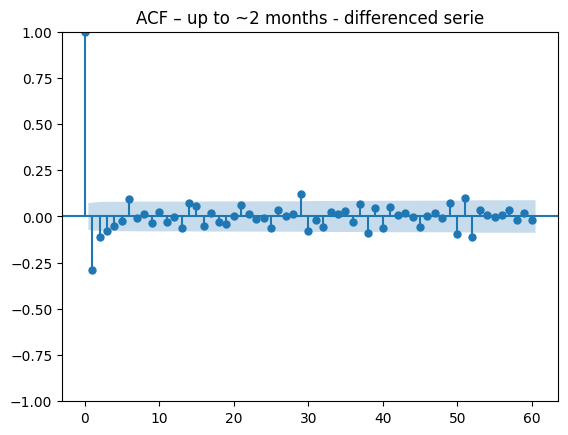

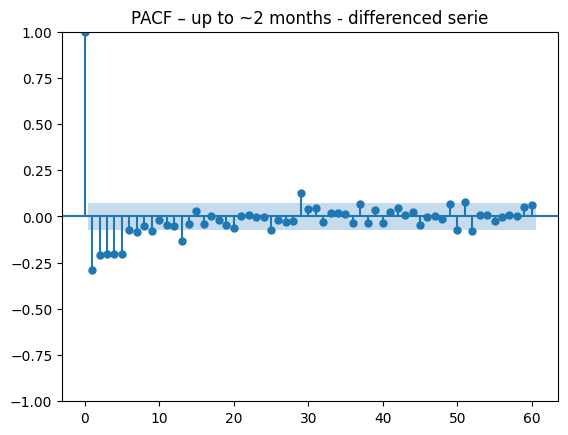

In [21]:
plot_acf(x1.dropna(), lags=60); plt.title("ACF – up to ~2 months - differenced serie"); plt.show()
plot_pacf(x1.dropna(), lags=60); plt.title("PACF – up to ~2 months - differenced serie"); plt.show()